<a href="https://colab.research.google.com/github/nguynlb/practice-d2l/blob/master/ComputerVision/ImageSegmentation/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 -q install albumentations
!pip3 -q install torchmetrics
# !pip3 -q install segmentation_models_pytorch 

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchmetrics
from torchmetrics import Dice, JaccardIndex
# import segmentation_models_pytorch as smp
from typing import Tuple, Dict, List
from pathlib import Path

import os
from tqdm import tqdm

C:\Users\ADMIN\anaconda3\envs\d2l\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
def download_dataset():
    if 'google.colab' in str(get_ipython()):
        !wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
        !wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
            
        !tar -xf images.tar.gz
        !tar -xf annotations.tar.gz
    else:
        !python -m wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz  -o images.tar.gz
        !python -m wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz -o annotations.tar.gz
        import tarfile
        import os 
        cur_dir = os.getcwd()
        with tarfile.open("images.tar.gz") as f:
          f.extractall(path=f"{cur_dir}/data")
        with tarfile.open("annotations.tar.gz") as f:
          f.extractall(path=f"{cur_dir}/data")
        print("Done...")

In [4]:
data_path = Path("data")
if data_path.is_dir():
    print(f"Dataset has been downloaded. Skip downloading...")
else:
    download_dataset()

Dataset has been downloaded. Skip downloading...


# Plot image


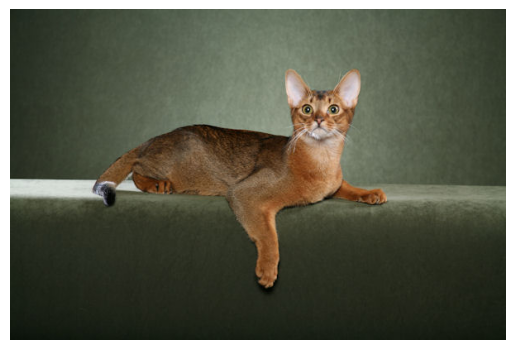

Shape of image: (400, 600, 3)


In [5]:
cur_dir = os.getcwd()

image_path = os.path.join(cur_dir,"data", "images", "Abyssinian_1.jpg")
image = cv2.imread(image_path)
image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_cvt)
plt.axis(False)
plt.show();

print(f"Shape of image: {image_cvt.shape}")

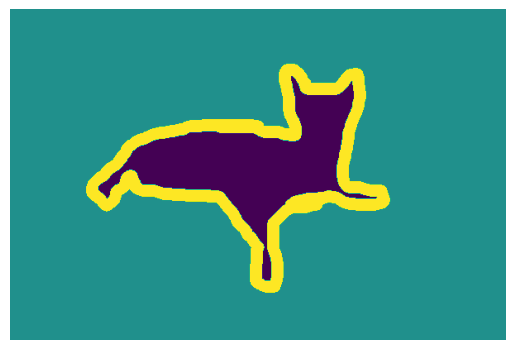

Shape of mark: (400, 600)


In [6]:
mark_path = os.path.join(cur_dir,"data", "annotations","trimaps","Abyssinian_1.png")
mark = cv2.imread(mark_path)
mark = cv2.cvtColor(mark, cv2.COLOR_BGR2GRAY)
plt.imshow(mark);
plt.axis(False)
plt.show();

print(f"Shape of mark: {mark.shape}")

# Custom Dataset

In [7]:
class DogCatDataset(Dataset):
  def __init__(self, root_dir : str ,txt_file : str, transform : A.Compose = None) -> None:
    super().__init__()

    self.root_dir = root_dir
    self.txt_file = txt_file
    self.transform = transform
    self.list_image_path = []
    with open(txt_file, "r") as file:
      for line in file:
        self.list_image_path.append(line.split()[0])

  def __len__(self) -> int:
    return len(self.list_image_path)

  def __getitem__(self, idx: int) -> Tuple[torch.Tensor]:
    # Read image
    image_path = os.path.join(self.root_dir, "images", f"{self.list_image_path[idx]}.jpg")
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    # Read mark
    mask_path = os.path.join(self.root_dir, "annotations", "trimaps" ,f"{self.list_image_path[idx]}.png")
    mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2GRAY)
    mask[mask == 2] = 0
    mask[mask == 3] = 1

    if self.transform is not None:
      transformed = self.transform(image=image, mask=mask)
      image = transformed['image']
      mask = transformed['mask']

    return image, mask

In [8]:
root_dir = "data"
txt_file = "data/annotations/trainval.txt"
dataset = DogCatDataset(root_dir=root_dir, txt_file=txt_file)

In [9]:
def denormalize_image(image: torch.Tensor) -> torch.Tensor:
  mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

  for i, m, s in zip(image, mean, std):
    i.mul_(s).add_(m)


  return image

In [10]:
def visualize_image_mark(dataset: DogCatDataset, n : int = 3,  seed: int = 82) -> None:
  """Visualize n-random picture and segmentation
  Args:
    - dataset: dataset want to visualize
    - n: number of picture
    - seed: seed random
  """
  np.random.seed(seed)
  size = len(dataset)

  fig, ax = plt.subplots(n, 2, figsize=(6, 6))

  for i in range(n):
    rand_idx = np.random.randint(size)
    image, mark = dataset[rand_idx]

    if isinstance(image, torch.Tensor):
      image = denormalize_image(image)
      image = image.permute(1, 2, 0)

    ax0 = ax[i, 0]
    ax0.imshow(image)
    ax0.set_title("Image")
    ax0.get_xaxis().set_visible(False)
    ax0.get_yaxis().set_visible(False)

    ax1 = ax[i, 1]
    ax1.imshow(mark)
    ax1.set_title("Segmentation")
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)


  plt.show()

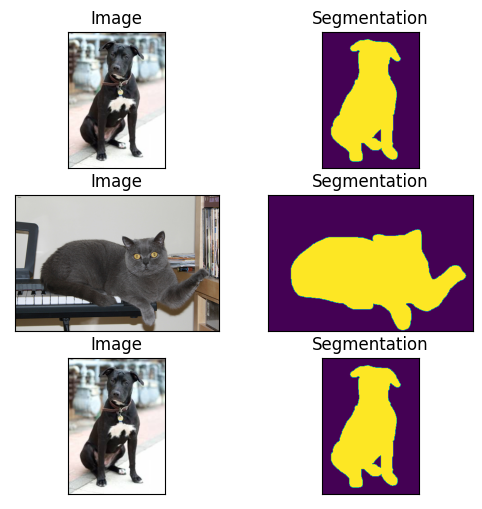

In [11]:
visualize_image_mark(dataset)

C:\Users\ADMIN\anaconda3\envs\d2l\lib\site-packages\albumentations\augmentations\dropout\cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


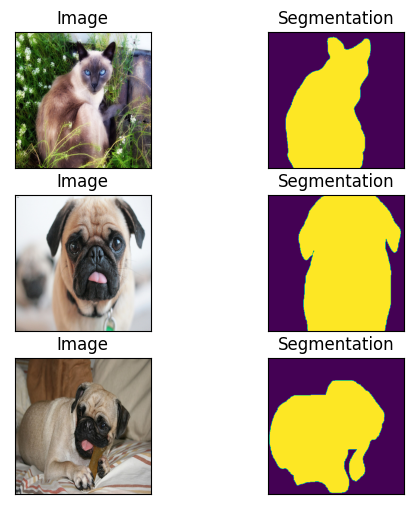

In [12]:
transform_size = 384

train_transform = A.Compose([
    A.Resize(width=transform_size, height=transform_size),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
    A.Normalize(),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(width=transform_size, height=transform_size),
    A.Normalize(),
    ToTensorV2()
])

root_dir = "/data"
train_file = "/data/annotations/trainval.txt"
test_file = "/data/annotations/test.txt"

train_dataset = DogCatDataset(root_dir=root_dir,
                              txt_file=train_file,
                              transform=train_transform)

test_dataset = DogCatDataset(root_dir=root_dir,
                             txt_file=test_file,
                             transform=test_transform)


visualize_image_mark(dataset=test_dataset, seed=2)

In [13]:
batch_size = 2


train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=batch_size,
                              shuffle=False)



In [14]:
class UNet(nn.Module):
  def __init__(self, in_channels: int = 3, hidden_channels: List[int] = [64, 128, 256, 512, 1025]) -> None:
    super(UNet, self).__init__()

    if (len(hidden_channels) != 5):
      raise AttributeError(f"""
      UNet is implemented with 4 depth layers and 1 latent space.
      Size of hidden_channels must be 5. Find {len(hidden_channels)}
      """)

    def conv2d_block(in_channels, out_channels) -> nn.Module:
      return nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 3, padding="same"),
          nn.ReLU(),
          nn.Conv2d(out_channels, out_channels, 3, padding="same"),
          nn.ReLU(),
      )


#     self.n_class = n_class

    # Encoder block
    self.down_sample = nn.MaxPool2d(2)
    self.downblock_0 = conv2d_block(in_channels, hidden_channels[0])
    self.downblock_1 = conv2d_block(hidden_channels[0], hidden_channels[1])
    self.downblock_2 = conv2d_block(hidden_channels[1], hidden_channels[2])
    self.downblock_3 = conv2d_block(hidden_channels[2], hidden_channels[3])

    # Latent Space
    self.latent_block = conv2d_block(hidden_channels[3], hidden_channels[4])

    # Decoder block
    self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear')
    self.upblock_3 = conv2d_block(hidden_channels[4] + hidden_channels[3], hidden_channels[3])
    self.upblock_2 = conv2d_block(hidden_channels[3] + hidden_channels[2], hidden_channels[2])
    self.upblock_1 = conv2d_block(hidden_channels[2] + hidden_channels[1], hidden_channels[1])
    self.upblock_0 = conv2d_block(hidden_channels[1] + hidden_channels[0], hidden_channels[0])

    # Output
    self.output = nn.Conv2d(hidden_channels[0], 1, 1, padding="same")

  def forward(self, x : torch.Tensor) -> torch.Tensor:
    # Encoder Block 0
    x0 = self.downblock_0(x)
    x = self.down_sample(x0)

    # Encoder Block 1
    x1 = self.downblock_1(x)
    x = self.down_sample(x1)

    # Encoder Block 2
    x2 = self.downblock_2(x)
    x = self.down_sample(x2)

    # Encoder Block 3
    x3 = self.downblock_3(x)
    x = self.down_sample(x3)

    # Latent Space
    x = self.latent_block(x)

    # Decoder Block 3
    x = self.up_sample(x)
    x = torch.cat((x3, x), dim = 1)
    x = self.upblock_3(x)

    # Decoder Block 2
    x = self.up_sample(x)
    x = torch.cat((x2, x), dim = 1)
    x = self.upblock_2(x)

    # Decoder Block 1
    x = self.up_sample(x)
    x = torch.cat((x1, x), dim = 1)
    x = self.upblock_1(x)

    # Decoder Block 0
    x = self.up_sample(x)
    x = torch.cat((x0, x), dim = 1)
    x = self.upblock_0(x)
    return self.output(x)


## Exploding model

In [17]:
# device = "cuda"
# unet = UNet(in_channels = 3).to(device)
# sample = sample.to("cuda")

# res = unet(sample)

## Training Model

### Create class score

In [18]:
class AverageScore(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.sum = 0
        self.count = 0
        self.avg = 0
        
    def update(self, val, n=1):
        self.count += n
        self.sum += val
        self.avg = self.sum / self.count

In [19]:
def accuracy_fn(y_pred : torch.Tensor, y_true: torch.Tensor) -> float:
    # y_pred, y_true is same shape
    # y_pred : (..., width, height)
    size = y_true.shape[0] * y_true.shape[1]
    return (y_pred == y_true).sum() / size

In [40]:
# arg
# device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

# Model
model = UNet().to(device)

# Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)


# Metrics
iou_fn = torchmetrics.JaccardIndex(num_classes=2, average="macro", task='binary').to(device)
dice_fn = torchmetrics.Dice(num_classes=2, average="macro").to(device)

# Train Score
train_acc_score = AverageScore()
train_loss_score = AverageScore()
train_dice_score = AverageScore()
train_iou_score = AverageScore()

# Test Score
test_acc_score = AverageScore()
test_loss_score = AverageScore()
test_dice_score = AverageScore()
test_iou_score = AverageScore()

In [41]:
iou_fn.__class__.__base__.__base__

torchmetrics.metric.Metric

In [45]:
def train_step(model: nn.Module, 
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               AverageScoreList: Tuple[AverageScore], 
               device: torch.device = device) -> None:
    model.train()
    train_acc_score, train_loss_score, train_dice_score, train_iou_score = AverageScoreList
     
    train_acc_score.reset()
    train_loss_score.reset()
    train_dice_score.reset()
    train_iou_score.reset()
    
    for idx, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.type(torch.float).to(device), y.type(torch.float).to(device)
        
        y_pred = model(X)
        y_pred = y_pred.squeeze(dim = 1)
        optimizer.zero_grad()
        loss_score = loss_fn(y_pred, y)
        loss_score.backward()
        optimizer.step()
        
        
        with torch.inference_mode():
            y_pred_mask = torch.round(y_pred.sigmoid()).long()
            acc_score = accuracy_fn(y_pred_mask, y)
            iou_score = iou_fn(y_pred_mask, y.long())
            dice_score = dice_fn(y_pred_mask, y.long())
            
            train_acc_score.update(acc_score.item())
            train_loss_score.update(loss_score.item())
            train_iou_score.update(iou_score.item())
            train_dice_score.update(dice_score.item())
            
            if idx % 40 == 0:
                print("Train Loss {:.4f} | Accuracy {:.4f} | IOU {:.4f} | Dice {:.4f}".format(
                    train_loss_score.avg, train_acc_score.avg,  train_iou_score.avg,  train_dice_score.avg
                ))

In [46]:
train_step(model=model, 
           dataloader = test_dataloader, 
           loss_fn=loss_fn, 
           optimizer=optimizer, 
           AverageScoreList=(train_acc_score, train_loss_score, train_dice_score, train_iou_score))

  0%|                                                                     | 0/1835 [00:05<?, ?it/s]


KeyboardInterrupt: 